phase list size:  766  amp list size:  766


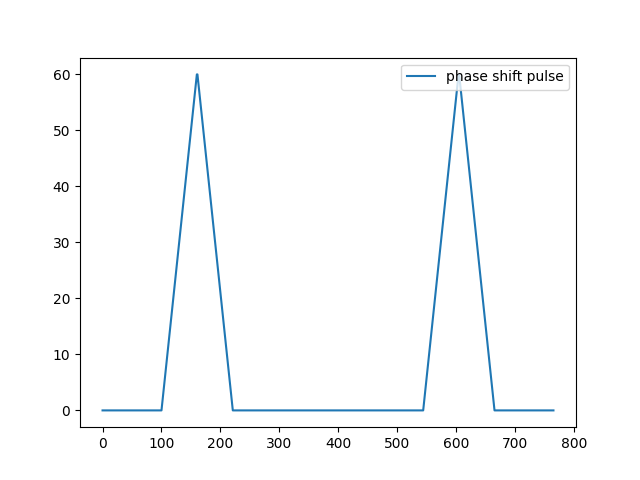

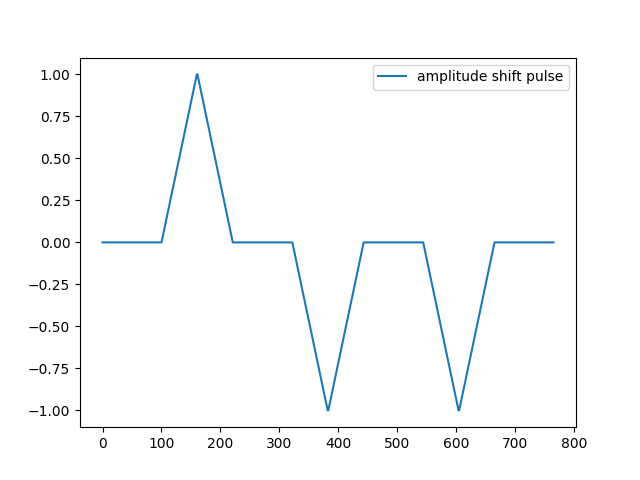

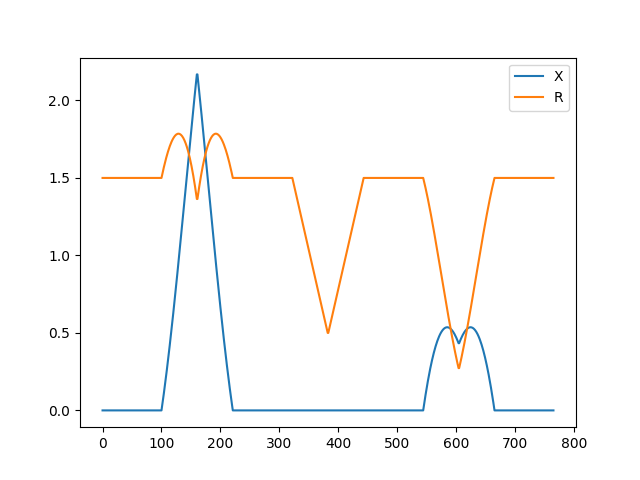

In [3]:
%matplotlib widget
from wavefunctions import GenerateSinewavePoints, GenerateSinewavePeriods
import matplotlib.pyplot as plt
import numpy as np

# wave and sampling parameters
sampleRate = 500000.0
frequency = 10000.0
amplitude = 1.5
numCycles = 3

# wave and sampling calculations
period = 1.0/frequency #seconds per cycle
samplesPerCycle = sampleRate/frequency

# set up the plot
#plt.axhline(y = 0.0, color = 'g', linestyle = '--') 

phasePulseMax = 60;
phasePulseInterval = 1.0;
phasePulseList = np.concatenate((
    np.zeros(100), 
    np.arange(0, phasePulseMax + phasePulseInterval, phasePulseInterval), 
    np.arange(phasePulseMax, 0 - phasePulseInterval, -1 * phasePulseInterval),
    np.zeros(100),
    np.zeros(np.arange(0, phasePulseMax + phasePulseInterval, phasePulseInterval).size),
    np.zeros(np.arange(phasePulseMax, 0 - phasePulseInterval, -1 * phasePulseInterval).size),
    np.zeros(100),
    np.arange(0, phasePulseMax + phasePulseInterval, phasePulseInterval),
    np.arange(phasePulseMax, 0 - phasePulseInterval, -1 * phasePulseInterval),
    np.zeros(100), 
))

ampPulseMax = 1.0;
ampPulseInterval = 1.0/phasePulseMax * ampPulseMax; # make the size match the phase list
ampPulseList = np.concatenate((
    np.zeros(100),
    np.arange(0, ampPulseMax + ampPulseInterval, ampPulseInterval), 
    np.arange(ampPulseMax, 0 - ampPulseInterval, -1 * ampPulseInterval),
    np.zeros(100),
    np.arange(0, -1 * ampPulseMax - ampPulseInterval, -1 * ampPulseInterval),
    np.arange(-1 * ampPulseMax, 0 + ampPulseInterval, ampPulseInterval),
    np.zeros(100),
    np.arange(0, -1 * ampPulseMax - ampPulseInterval, -1 * ampPulseInterval),
    np.arange(-1 * ampPulseMax, 0 + ampPulseInterval, ampPulseInterval),
    np.zeros(100), 
))

fig = plt.figure()
plt.plot(phasePulseList, label="phase shift pulse")
plt.legend(loc="upper right")
fig = plt.figure()
plt.plot(ampPulseList, label="amplitude shift pulse")
plt.legend(loc="upper right")

if phasePulseList.size != ampPulseList.size:
    print("Error: phase and amp list sizes don't match")
    exit()

print("phase list size: ", phasePulseList.size, " amp list size: ", ampPulseList.size)

fig = plt.figure()

signalX = []
signalR = []
for i in range(0, phasePulseList.size):
    phase = phasePulseList[i]
    finalAmplitude = amplitude + ampPulseList[i];
    signal = finalAmplitude * np.sin(np.linspace(0, period * numCycles, int(samplesPerCycle*numCycles)) * 2*np.pi*frequency + np.deg2rad(phase))
    #plt.plot(signal, label="phase: " + str(phase))
    sampleX = signal[0]
    signalX.append(sampleX)
    sampleR = signal[int(samplesPerCycle/4)]
    signalR.append(sampleR)
    #print("phase: ", phase, " X: ", sampleX, " R: ", sampleR)


plt.plot(signalX, label="X")
plt.plot(signalR, label="R")
plt.legend(loc="upper right")